# Titanic Data Analysis
**Data Cleaning**



In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
df = pd.read_csv('titanic_data.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
df.describe()

/Users/johnhagler/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,NaN,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,NaN,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,NaN,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Missing values in Age, Cabin, and Embarked

## Determine missing values

### Embarked

In [5]:
df.groupby('Embarked').count()['PassengerId']

Embarked
C    168
Q     77
S    644
Name: PassengerId, dtype: int64

Most of the passengers embarked from 'S'.  There are two missing values.  We will fill these with 'S'.

In [6]:
df['Embarked'].fillna('S', inplace=True)

Replace the letter code, with the port.

In [7]:
def get_port_name(letter):
    if letter == 'C':
        return 'Cherbourg'
    elif letter == 'Q':
        return 'Queenstown'
    elif letter == 'S':
         return 'Southampton'
    else:
        return letter
    
df['embarked_port'] = df['Embarked'].apply(get_port_name)

### Passenger Class
Passenger Class is encoded so that 1=Upper class, 2=Middle class, and 3=Lower class.  A new column, "ses" for socioeconomic status will be created with readable labels.



In [8]:
def ses(pclass):
    if pclass == 1:
        return 'Upper class'
    elif pclass == 2:
        return 'Middle class'
    elif pclass == 3:
        return 'Lower class'
    else:
        return 'Unknown'
    
df['ses'] = df['Pclass'].apply(ses)

### Cabin
The Cabin field is missing 687 (77%) values.  We are not be able to accurately impute the missing values.

### Age
The Age field is missing 177 (20%) values.  There does not appear to be a lot of good data to be able to impute specific ages.  Taking the mean age and replacing the missing values is an option, but it may too strongly reinforce the current mean.  An option may be to create a new feature, "passenger_group" that divides passengers into "Men, women, and children".  Sex, age, and the passenger's salutation can be used to assign the groups.  The salutation can be extracted from the name.  This field helps give us additional information for passengers whose age is missing from the data.  

Males over the age of 18 or passengers with the salutaiton of "Mr" or "Dr" can be considered men  Females over the age of 18 or passengers with the saluation of "Mrs" can be considered women.  Passengers under the age of 18 or with the salutation of miss or master can be considered children.

In [9]:
def get_salutation(name):
    m = re.search('(.*,)(.*)(\..*)', name)
    return m.group(2).strip()
df['salutation'] = df['Name'].apply(get_salutation)

In [10]:
df[['salutation','Name']].head()

,salutation,Name
0,Mr,"Braund, Mr. Owen Harris"
1,Mrs,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
2,Miss,"Heikkinen, Miss. Laina"
3,Mrs,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
4,Mr,"Allen, Mr. William Henry"


In [11]:
def get_passenger_group(sex, age, name, salutation):
    if (sex == 'male' and age >= 18) or (salutation == 'Mr' or salutation == 'Dr'):
        return 'Men'
    elif (sex == 'female' and age >= 18) or (salutation == 'Mrs'):
        return 'Women'
    elif (age < 18) or (salutation == 'Miss' or salutation == 'Master'):
        return 'Children'
    else:
        return 'Unknown'
    
df['passenger_group'] = df.apply(lambda x: get_passenger_group(x['Sex'], x['Age'], x['Name'], x['salutation']), axis=1)

In [12]:
df[df['passenger_group'] == 'Unknown'].count()['PassengerId']

0

All passengers have been assigned a PassengerGroup.

## Outliers

## Fare

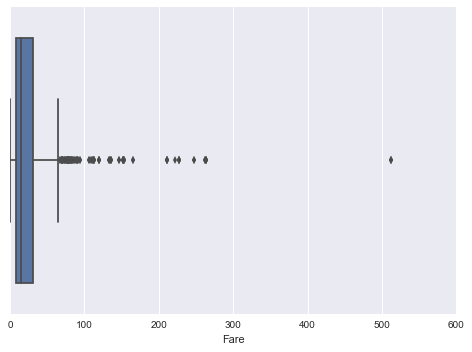

In [13]:
sns.boxplot(df['Fare'])

There appears to be an extreme outlier for "Fare".  However, after reseasrching fares pade for first class on the Titanic, this value may be accurate.

## Identify family groups

In [14]:
def has_family(sibsp, parch):
    return sibsp + parch > 0

df['has_family'] = df.apply(lambda x: has_family(x['SibSp'], x['Parch']), axis=1)


In [15]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,embarked_port,ses,salutation,passenger_group,has_family
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Southampton,Lower class,Mr,Men,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Cherbourg,Upper class,Mrs,Women,True
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Southampton,Lower class,Miss,Women,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Southampton,Upper class,Mrs,Women,True
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Southampton,Lower class,Mr,Men,False


The modified data frame is saved to a "cleaned" version of the data.

In [16]:
df.to_csv('titanic_data_cleaned.csv')